In [1]:
# Third-party
import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gala.integrate as gi
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from pyia import GaiaData

In [2]:
t1 = Table.read('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')
t2 = Table.read('/Users/adrian/data/APOGEE_DR15beta/APOGEE_preDR15_SH_release_Feb2019.fits')

t = join(t1, t2, keys='APOGEE_ID')
t = t[t['SH_OUTPUTFLAGS'] == '']
len(t)

347318

In [3]:
apogee_g = GaiaData(t)

In [4]:
sgr_c = coord.SkyCoord(ra=283.8313*u.deg, dec=-30.5453*u.deg)
sgr_c.galactic

<SkyCoord (Galactic): (l, b) in deg
    (5.56891746, -14.16646316)>

In [5]:
apogee_c = apogee_g.get_skycoord(distance=False)

In [6]:
sgr_mask = (apogee_c.separation(sgr_c) < 2*u.deg) & (apogee_g.VSCATTER < 1.)
sgr_g = apogee_g[sgr_mask]

In [7]:
len(sgr_g)

1056

Text(0.5,0,'RV [km/s]')

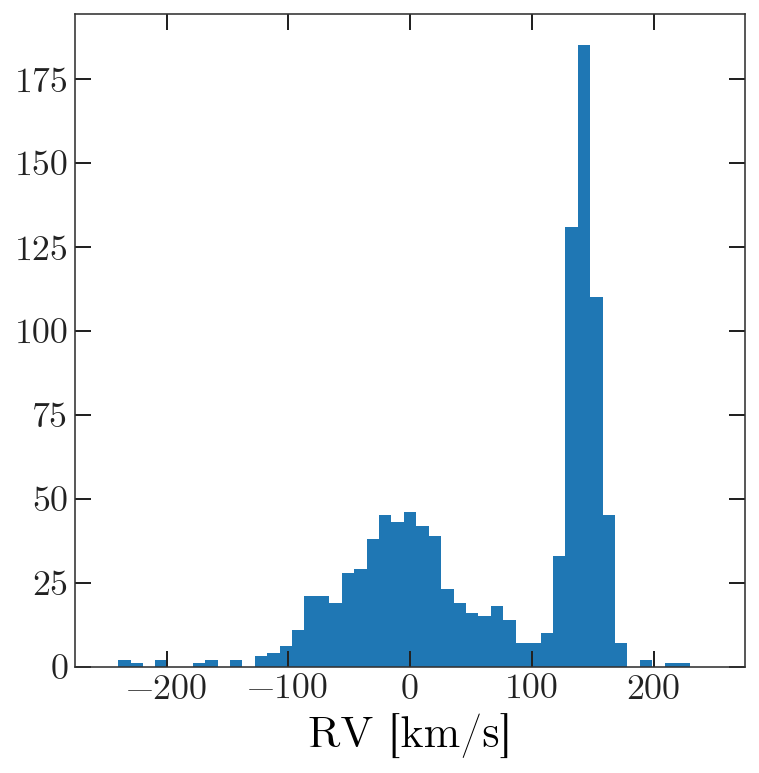

In [8]:
plt.hist(sgr_g.VHELIO_AVG, bins=np.linspace(-250, 250, 50));
plt.xlabel('RV [km/s]')

In [9]:
sgr_rv_g = sgr_g[sgr_g.VHELIO_AVG > 50.]

(-15, 15)

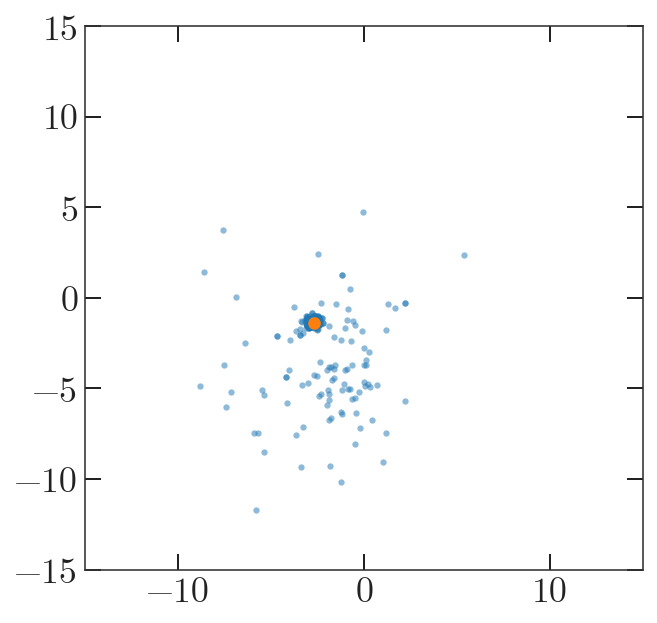

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(sgr_rv_g.pmra, sgr_rv_g.pmdec,
           alpha=0.5, linewidth=0, s=10)
ax.scatter(np.median(sgr_rv_g.pmra), 
           np.median(sgr_rv_g.pmdec),
           alpha=1, linewidth=0, s=40)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)

In [11]:
pm_mask = np.sqrt((sgr_rv_g.pmra - np.median(sgr_rv_g.pmra))**2 + 
                  (sgr_rv_g.pmdec - np.median(sgr_rv_g.pmdec))**2) < 1.*u.mas/u.yr

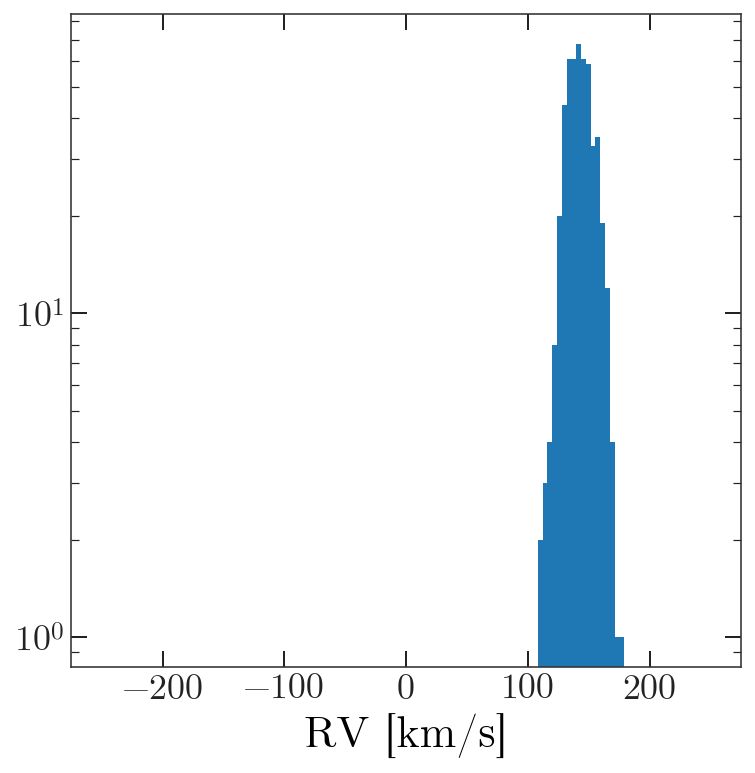

In [12]:
plt.hist(sgr_rv_g.VHELIO_AVG[pm_mask & (sgr_rv_g.VHELIO_AVG > 100.)], 
         bins=np.linspace(-250, 250, 128));
plt.xlabel('RV [km/s]')
plt.yscale('log')

In [17]:
_rv = sgr_rv_g.VHELIO_AVG[pm_mask & (sgr_rv_g.VHELIO_AVG > 100.) & (sgr_rv_g.VHELIO_AVG < 200.)]
np.std(_rv), 1.5 * np.median(_rv - np.median(_rv))

(11.148822, 1.1444091796875e-05)

In [18]:
sgr_member_mask = pm_mask & (sgr_rv_g.VHELIO_AVG > 100.)
sgr_members = sgr_rv_g[sgr_member_mask]

In [84]:
rv = sgr_members.VHELIO_AVG
ivar = 1 / (sgr_members.VERR**2 + sgr_members.VSCATTER**2)

sgr_rv = np.sum(rv * ivar) / np.sum(ivar)
sgr_rv, np.sqrt(1 / np.sum(ivar))

(142.62701, 0.0007633293942791641)

In [83]:
np.mean(sgr_members.dist50)

24.68527

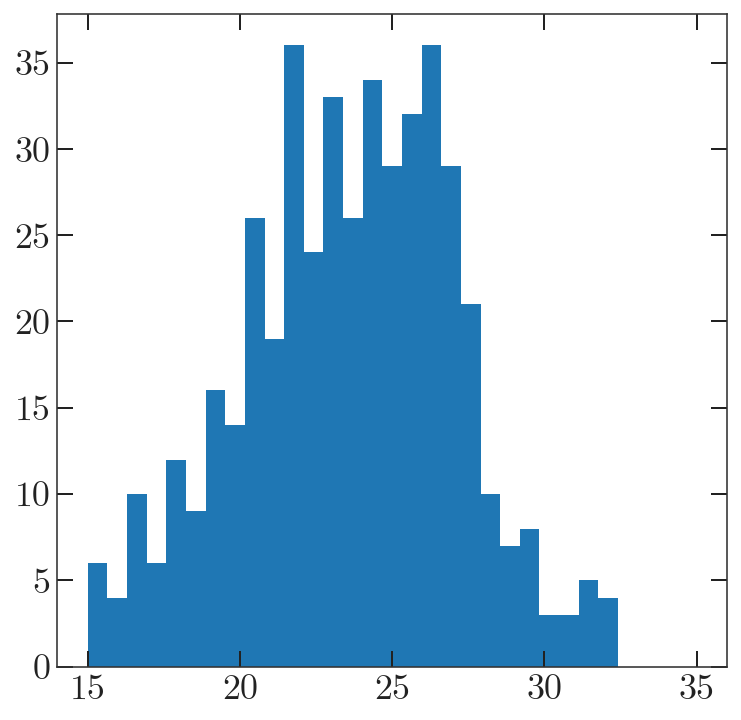

In [81]:
plt.hist(sgr_members.dist50, bins=np.linspace(15, 35, 32));

# Distances from Hogg et al.:

In [5]:
hogg = GaiaData('/Users/adrian/data/APOGEE_DR14/HoggEilersRix-APOGEE.fits')

In [12]:
hogg_c = coord.SkyCoord(ra=hogg.ra_1*u.deg, dec=hogg.dec_1*u.deg,
                        distance=coord.Distance(parallax=hogg.spec_parallax*u.mas),
                        pm_ra_cosdec=hogg.pmra,
                        pm_dec=hogg.pmdec,
                        radial_velocity=hogg.VHELIO_AVG*u.km/u.s)

In [29]:
hogg_sgr_mask = ((hogg_c.separation(sgr_c) < 2*u.deg) & (hogg.VSCATTER < 1.) &
                 (hogg_c.radial_velocity < 185*u.km/u.s) &
                 (hogg_c.radial_velocity > 100*u.km/u.s))
hogg_sgr_g = hogg[hogg_sgr_mask]
hogg_sgr_c = hogg_c[hogg_sgr_mask]

Text(0.5,0,'RV [km/s]')

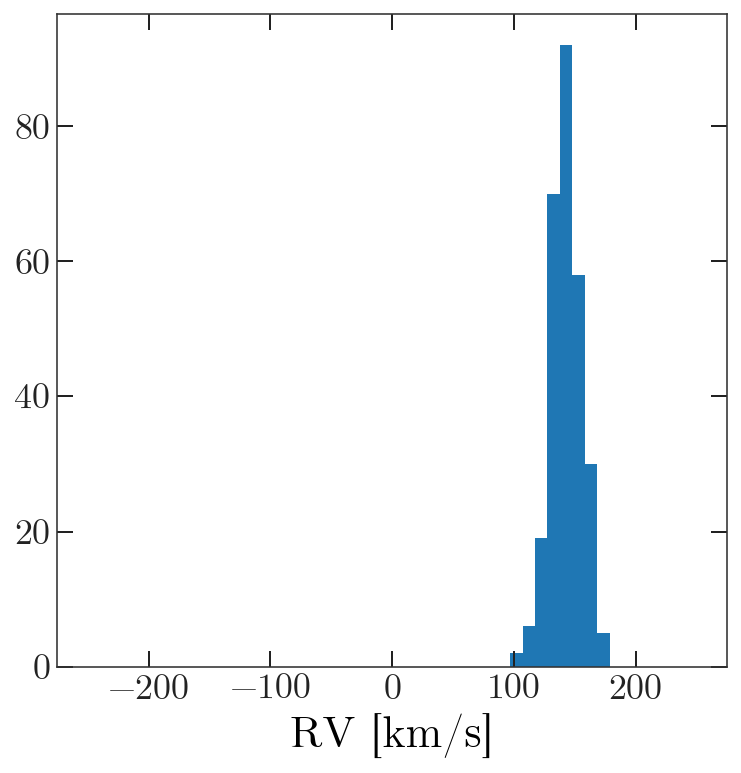

In [30]:
plt.hist(hogg_sgr_c.radial_velocity.value, bins=np.linspace(-250, 250, 50));
plt.xlabel('RV [km/s]')

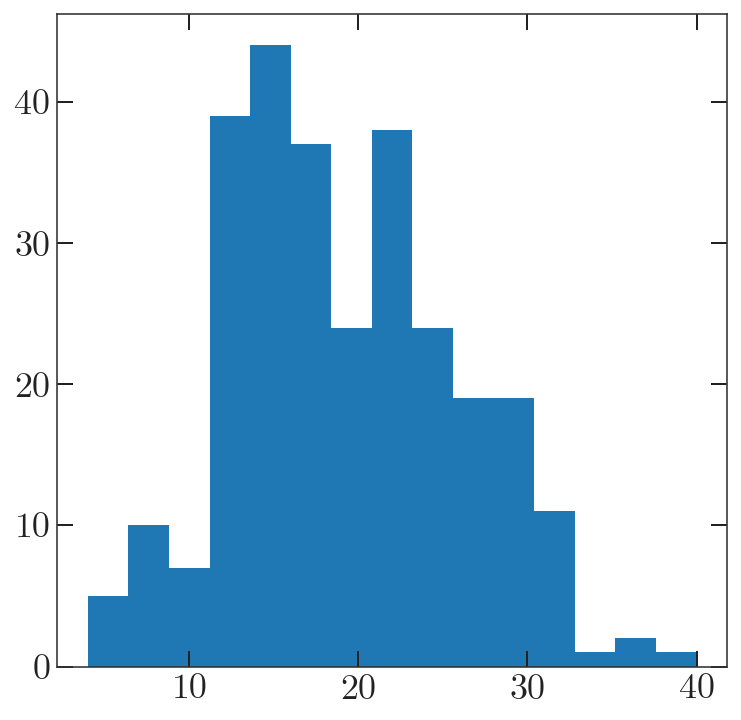

In [32]:
plt.hist(hogg_sgr_c.distance.to_value(u.kpc), bins=np.linspace(4, 40, 16));

In [42]:
ivar = 1 / hogg_sgr_g.spec_parallax_err**2
mean_plx = np.sum(hogg_sgr_g.spec_parallax * ivar) / np.sum(ivar)
mean_plx_err = np.sqrt(1 / np.sum(ivar))
plx_samples = np.random.normal(mean_plx, mean_plx_err, 100000)
dist_samples = coord.Distance(parallax=plx_samples*u.mas)

dist = np.mean(dist_samples)
dist_err = np.std(dist_samples)

dist, dist_err

(<Distance 22502.9867744 pc>, <Distance 189.26580617 pc>)

## Sgr stream:

In [57]:
stream_c = hogg_c.transform_to(gc.Sagittarius)
Beta_mask = np.abs(stream_c.Beta) < 10*u.deg
stream_c = stream_c[Beta_mask]

(-0.2, 0.6)

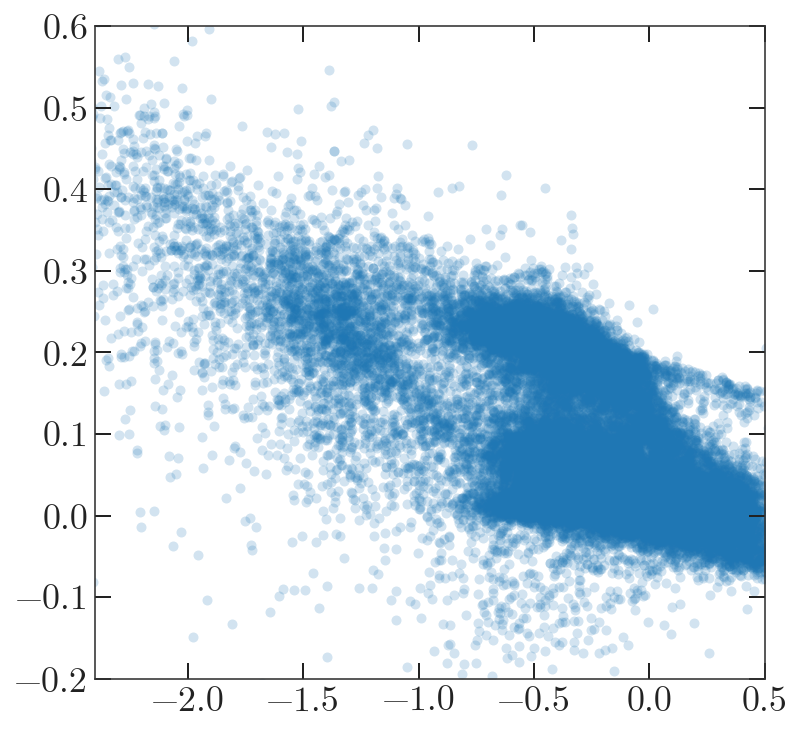

In [65]:
plt.scatter(hogg.M_H, hogg.ALPHA_M,
            alpha=0.2, lw=0)
plt.xlim(-2.4, 0.5)
plt.ylim(-0.2, 0.6)

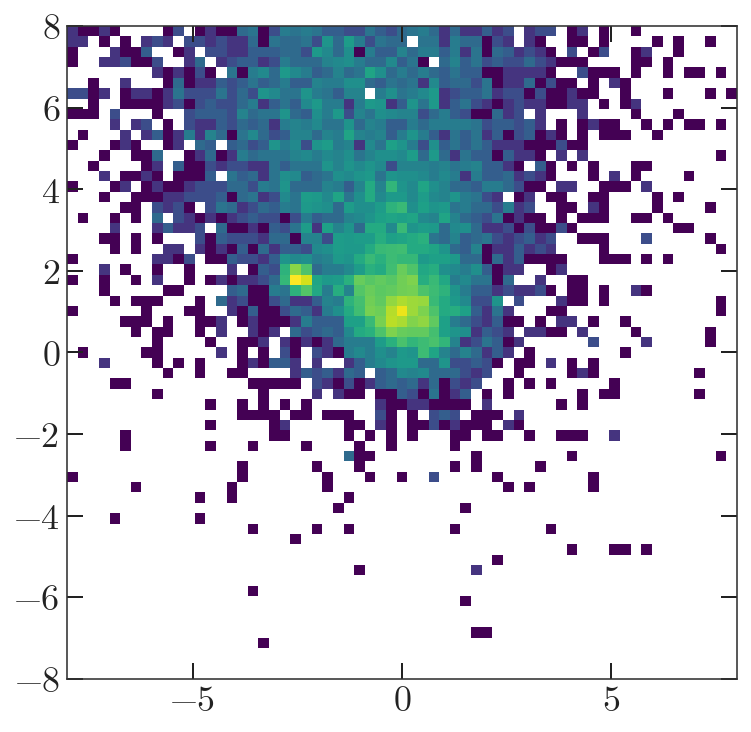

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist2d(stream_c.pm_Lambda_cosBeta,
          stream_c.pm_Beta,
          bins=np.linspace(-8, 8, 64),
          norm=mpl.colors.LogNorm());

# Orbits:

In [163]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)

# APW MW model
mw = gp.MilkyWayPotential()

# Hernquist model
# rs = 18.3 * u.kpc
# c = 9.39
# a = rs * np.sqrt(2 * (np.log(1+c) - c/(1+c)))
# M = 1.29E12 * u.Msun
# mw = gp.HernquistPotential(m=M, c=a, units=galactic)

In [164]:
sgr_c = coord.SkyCoord(ra=283.8313*u.deg, dec=-30.5453*u.deg,
                       distance=25*u.kpc, 
                       pm_ra_cosdec=-2.692*u.mas/u.yr,
                       pm_dec=-1.359*u.mas/u.yr,
                       radial_velocity=sgr_rv*u.km/u.s)

In [165]:
galcen = sgr_c.transform_to(galcen_frame)

In [166]:
w0 = gd.PhaseSpacePosition(galcen.data)

In [185]:
dt = -1*u.Myr
n_steps = 8000
orbit = mw.integrate_orbit(w0, dt=dt, n_steps=n_steps)

In [186]:
orbit.pericenter(), orbit.apocenter()

(<Quantity 13.73208633 kpc>, <Quantity 45.15584082 kpc>)

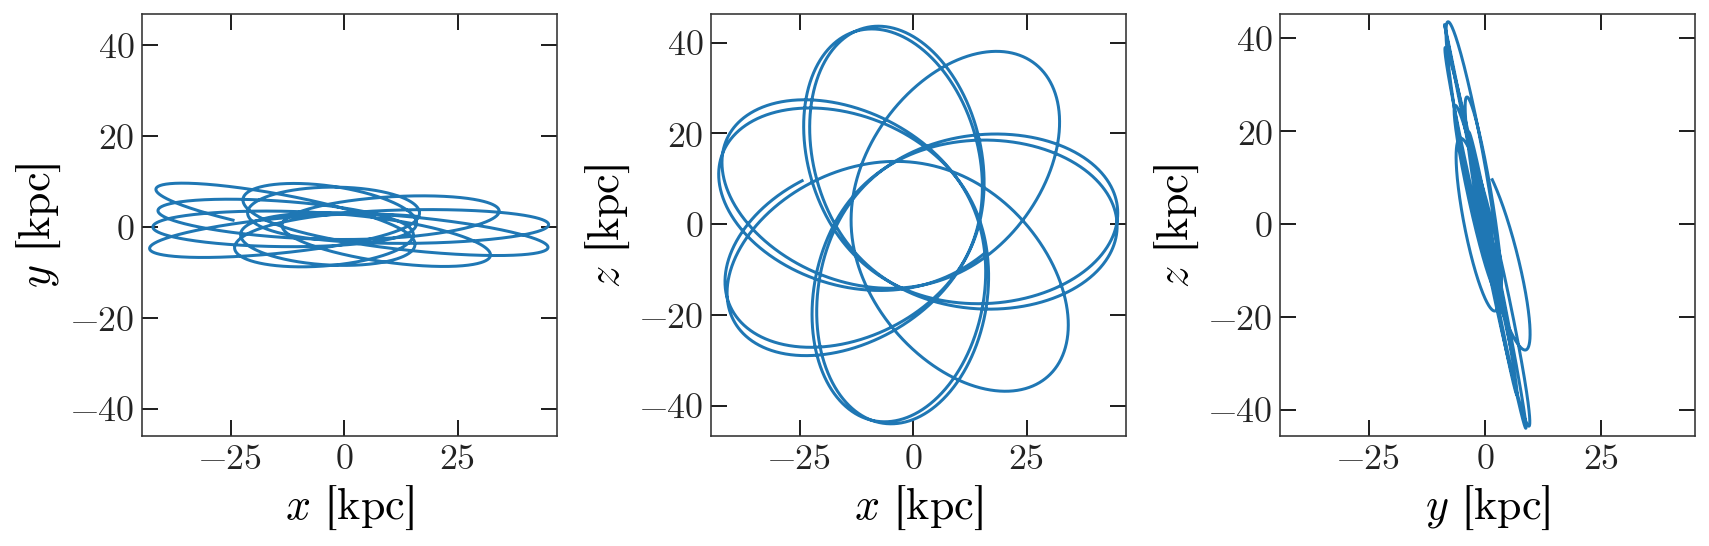

In [187]:
_ = orbit.plot()

### Try orbits with dynamical friction:

In [188]:
# vmax = (230*u.km/u.s).to_value(u.kpc/u.Myr)
# rs = (15*u.kpc).to_value(u.kpc)

def sigma(r):
    rs = 15.
    vmax = 0.2352237979623528
    x = r / rs
    return vmax * (1.4393*x**0.354) / (1 + 1.1756*x**0.725)
    
def F(t, w, mw, Msat):
    x = w[:3] # kpc
    v = w[3:] # kpc/Myr
    
    r = np.sqrt(np.sum(x**2, axis=0)) 
    vmag = np.sqrt(np.sum(v**2, axis=0))
    
    # terms in the DF formula from Besla et al. 2007
    # lnL = np.log(r / (4.2*u.kpc)) 
    lnL = np.log(r / 4.2) 
    # lnL = np.log(10. / 4.2) 
    X = vmag / (np.sqrt(2) * sigma(r))
    G = mw.G
#     rho = mw.density(x).value
    rho = mw._density(np.ascontiguousarray(x.T), np.array([0.]))
    
    A = -4*np.pi * G**2 * Msat.to_value(u.Msun) * lnL * rho / vmag**2
    B = np.erf(X) - 2*X/np.sqrt(np.pi) * np.exp(-X**2)
    
    acc_DF = A * B * v / vmag
#     acc = mw.acceleration(x).value + acc_DF
    acc = -mw._gradient(np.ascontiguousarray(x.T), np.array([0.])).T + acc_DF # .to(u.kpc/u.Myr**2)
    
    return np.vstack((v, acc))

In [191]:
sgr_mass = 1e10*u.Msun
integrator = gi.DOPRI853Integrator(F, (mw, sgr_mass), 
                                   func_units=galactic)
orbit_df = integrator.run(w0, dt=dt, n_steps=n_steps)

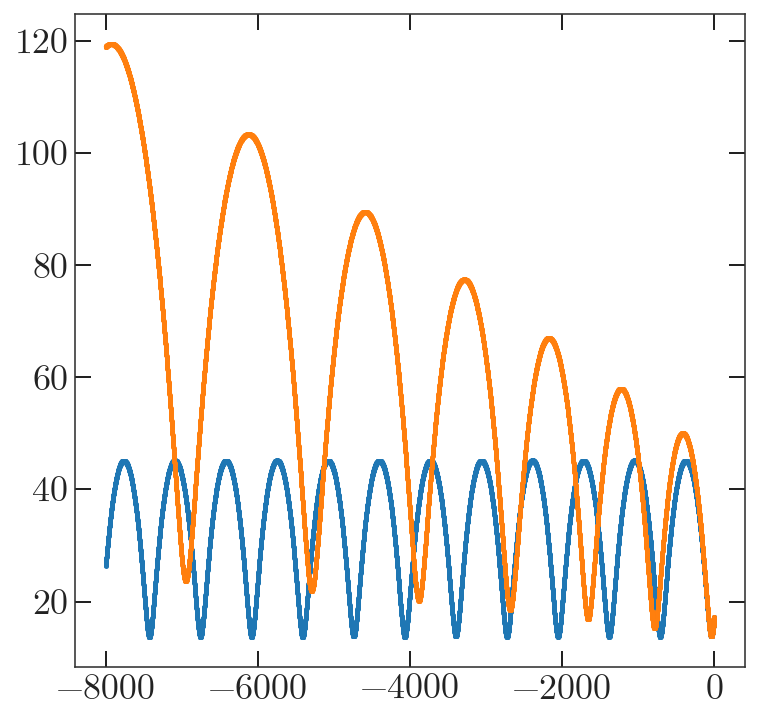

In [192]:
plt.plot(orbit.t, orbit.spherical.distance)
plt.plot(orbit_df.t, orbit_df.spherical.distance)

In [196]:
peris, times = orbit.pericenter(return_times=True, func=None)

orbit.z[np.abs(orbit.t-times[-1]).argmin()], orbit.z[np.abs(orbit.t-times[-2]).argmin()]

(<Quantity -12.73906004 kpc>, <Quantity 6.96015191 kpc>)

(-20, 20)

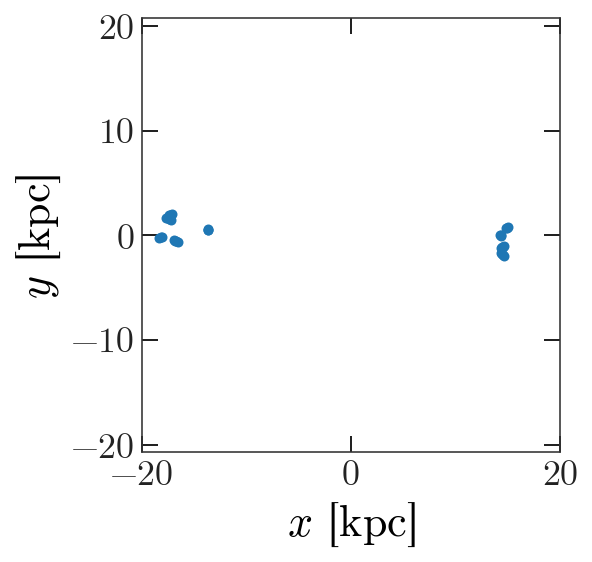

In [206]:
fig = orbit[np.abs(orbit.z) < 0.5*u.kpc].plot(['x', 'y'], 
                                            marker='o', linestyle='none')
fig.axes[0].set_xlim(-20, 20)
fig.axes[0].set_ylim(-20, 20)